Michael Wilson

DSC-609: Machine Learning

Programming Assignment 7 - Unsupervised methods

## Assignment Introduction

For this assignment, we will use a dataset posted on Kaggle for the purposes of demonstrating some unsupervised learning algorithms.  In this case we will specifically be doing some Principal Components Analysis, as well as Density-Based clustering of the data.

## Dataset

The dataset used for this assignment is the Heart Failure Prediction Dataset, compiled and posted on Kaggle by user fedesoriano. The dataset is available for public download from https://www.kaggle.com/fedesoriano/heart-failure-prediction. This dataset is actually a compilation covering 11 features describing each patient's select characteristics that are being tracked along with their status as it relates to the presence of heart disease/failure. (fedesoriano, 2021)

The features tracked as independent variables are:

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

(fedesoriano, 2021)


In [1]:
# Load required packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Read in CSV data file and take a quick look

HeartDataRaw = pd.read_csv(r'C:\Users\Mike\Documents\Grad School 2021\DSC-609 Machine Learning\heart.csv')

HeartDataRaw.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Data Selection/Preprocessing

There are some columns that we don't wish to use.  First, HeartDisease is actually a target classification variable for this dataset, and clustering doesn't imply or require a target class.  Accordingly, we will drop that variable, as well as Oldpeak and ST_Slope, primarily because the data description is difficult to understand and the two variables are related to each other in that the ST_Slope is measured as up, flat, or down from OldPeak.

We will also encode the categorical variables for Sex, ChestPainType, RestingECG, and ExerciseAngina.

Lastly, the data will be scaled to the 0-1 range using scikit-learn's MinMaxScaler.

In [2]:
#Drop unwanted columns

HeartData = HeartDataRaw.drop(['Oldpeak','ST_Slope','HeartDisease'], axis = 1)

# Encode categorical columns

cat_columns = ['Sex','ChestPainType','ExerciseAngina']

for val in cat_columns:
    HeartData[val] = preprocessing.LabelEncoder().fit_transform(HeartData[val])

# ECG Results we just want separated to normal/not normal findings
HeartData['RestingECG'].replace(to_replace = 'Normal', value = 0, inplace = True)
HeartData['RestingECG'].replace(to_replace = ['ST','LVH'], value = 1, inplace = True)
HeartData.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina
0,40,1,1,140,289,0,0,172,0
1,49,0,2,160,180,0,0,156,0
2,37,1,1,130,283,0,1,98,0
3,48,0,0,138,214,0,0,108,1
4,54,1,2,150,195,0,0,122,0


In [3]:
#Scale the selected data using MinMaxScaler

minmaxscaler = MinMaxScaler()
HD_Scaled = minmaxscaler.fit_transform(HeartData)

We now transform the data using Principal Components Analysis, and keep just the first 2 principal components, so that we may visualize the data in those terms.

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
HD_pca = pca.fit_transform(HD_Scaled)

print("Original Data Shape:\t{}".format(str(HD_Scaled.shape)))
print("Reduced Data shape:\t{}".format(str(HD_pca.shape)))

Original Data Shape:	(918, 9)
Reduced Data shape:	(918, 2)


Visualizing the data in terms of the datasets first two principal components:

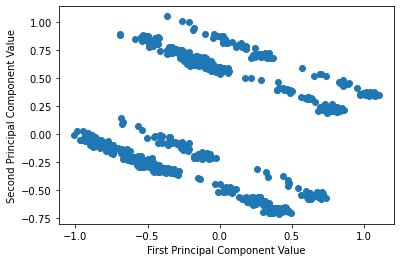

In [5]:
plt.scatter(HD_pca[:,0], HD_pca[:,1])
plt.xlabel("First Principal Component Value")
plt.ylabel("Second Principal Component Value")
plt.show()

Noting the above graph, we can see some data that looks like it could be separated by one or more linear classifiers.  This might also suggest some hierarchical clustering possibilities, as there appear to be 2 large groups of smaller clusters within.  The big separations and general linear nature, but along levels, might be a result of some of the categorical variable only taking a limited set of values, particularly the binary variables.

We can inspect the principal component values by original feature:

Text(0, 0.5, 'Principal components')

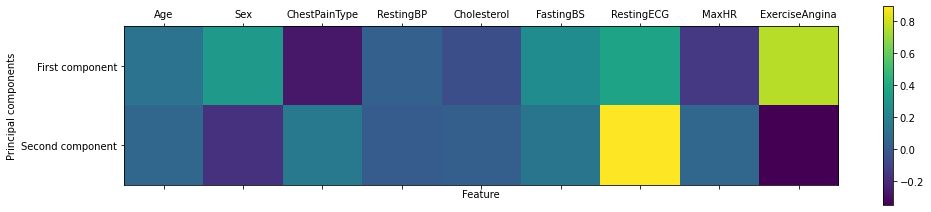

In [6]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(HeartData.columns)),
           HeartData.columns, rotation=0, ha='center')
plt.xlabel("Feature")
plt.ylabel("Principal components")

Looking at the heatmap, we can see that each principal component has coefficients with both signs in them, and at both extremes of the value ranges, although the negative magnitudes are smaller than the positive ones.

## Clustering Using DBSCAN

Now, we will try to fit the Density-Based Clustering method on the data as a way to see what that data has to say on its own.  We will first try with the data, only re-encoded for the categorical variables, but without any scaling. Then we will try with both scaled data and the principal components we found above.  We will start with the default algorithm settings, which looks for a minimum cluster size of 5 samples, and allows a distance of eps = 0.5 for inclusion.  

After that, we will do some iterative parameter tuning and checking with the silhouette coefficients, and looking at how many clusters were found and how many points were determined to not belong to a cluster. 

In [17]:
HD_dbscan = DBSCAN()

cluster_unscaled = HD_dbscan.fit_predict(HeartData)

cluster_scaled = HD_dbscan.fit_predict(HD_Scaled)

cluster_reduced = HD_dbscan.fit_predict(HD_pca)

print('Unscaled cluster assignments: \n{}'.format(cluster_unscaled))

print('MinMaxScaled cluster assignments: \n{}'.format(cluster_scaled))

print('PCA-based cluster assignments: \n{}'.format(cluster_reduced))

Unscaled cluster assignments: 
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -

Looking at the classing results using the default settings, we see that the un-scaled data came back unable to assign any data point to a class on the default settings.  With a default eps = 0.5, min_samples = 5, and seeing that some values in the features can be nearly 200 versus some that are 0 or 1, that's not surprising.  

When you look at the scaled data, it gets slightly more interesting, in that it found 15 clusters on default settings.  However, that may be too many, and there are still some points it did not group within a cluster.

Looking at the clustering on the first two principal components yields just two classes though, with no un-clustered points.  We'll iteratively adjust some model parameters to see what happens when we vary the required minimum cluster size and the allowable distance between core points.

In [19]:
# do some parameter tuning on the PCA-based clustering

from sklearn import metrics

e_p_s = [0.05, 0.1, 0.15, 0.2]
min_qty = [2,3,4,5,6,7,8,9]

for dist in e_p_s:
    for req in min_qty:
        PT_dbscan = DBSCAN(eps = dist, min_samples = req)
        PT_dbscan.fit_predict(HD_pca)
        cluster_count = len(set(PT_dbscan.labels_))-(1 if -1 in PT_dbscan.labels_ else 0)
        unclassed_points = list(PT_dbscan.labels_).count(-1)
        all_points = len(list(PT_dbscan.labels_))
        print('EPS = {:.2f}'.format(dist))
        print('\tMin Samples = {}'.format(req))
        print('\tNumber of Clusters found: {}'.format(cluster_count))
        print('\tPercent unclassed points: {:.2f}'.format(((unclassed_points)/(all_points))*100),'%')
        print('\tSilhouette Coefficient  : {:.3f}'.format(metrics.silhouette_score(HD_pca, PT_dbscan.labels_)))

EPS = 0.05
	Min Samples = 2
	Number of Clusters found: 25
	Percent unclassed points: 1.31 %
	Silhouette Coefficient  : 0.416
EPS = 0.05
	Min Samples = 3
	Number of Clusters found: 19
	Percent unclassed points: 2.61 %
	Silhouette Coefficient  : 0.430
EPS = 0.05
	Min Samples = 4
	Number of Clusters found: 18
	Percent unclassed points: 3.16 %
	Silhouette Coefficient  : 0.473
EPS = 0.05
	Min Samples = 5
	Number of Clusters found: 17
	Percent unclassed points: 3.70 %
	Silhouette Coefficient  : 0.475
EPS = 0.05
	Min Samples = 6
	Number of Clusters found: 17
	Percent unclassed points: 4.58 %
	Silhouette Coefficient  : 0.431
EPS = 0.05
	Min Samples = 7
	Number of Clusters found: 16
	Percent unclassed points: 5.45 %
	Silhouette Coefficient  : 0.459
EPS = 0.05
	Min Samples = 8
	Number of Clusters found: 16
	Percent unclassed points: 6.21 %
	Silhouette Coefficient  : 0.471
EPS = 0.05
	Min Samples = 9
	Number of Clusters found: 16
	Percent unclassed points: 6.21 %
	Silhouette Coefficient  : 0.471


The parameter settings of EPS = 0.15 and min_samples = 8 (or 9) returned the highest silhouette coefficients of about 0.56.  More interesting is that for all other EPS values tried, as the min_samples value was raised, fewer clusters were found, except at this distance setting, where the number of clusters discovered increased when the minimum cluster size was also increased.  Referring back to the graph above, you can see how increasing the distance allowed setting can end up including points from a nearby cluster if the analyst isn't mindful.

## References

fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [10 Dec 2021] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.